In [35]:
import numpy as np
import random as random
import math
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.interpolate import griddata
from decimal import *
from functools import reduce

setcontext(ExtendedContext)
getcontext().rounding = 'ROUND_UP'
getcontext().Emin = -2000
getcontext().Emax = 9
getcontext().rounding = ROUND_UP

%matplotlib inline




In [36]:
def makedata(M,mu,sigma):
    gauss_vec = [random.gauss(mu,sigma) for i in range(M)]
    output = ( ", ".join( str(e) for e in gauss_vec ) )
    f = open('data.out', 'w')
    f.write(output)
    return gauss_vec

def prior_unif(a,b):
    probability = 1.0/(b-a)
    return probability

def likelihood(data,mu,sig):
    likelihood_vec = (scipy.stats.norm(mu, sig).pdf(data))
    likelihood_vec = [Decimal(i) for i in likelihood_vec]
    likelihood_total = (np.prod(likelihood_vec))
    return likelihood_total

def mcmc(N,mu_min,mu_max,sig_min,sig_max,delta,file):
    data = np.loadtxt(file, delimiter=",", unpack=False)
    
    x_out = [0]*N
    y_out = [0]*N
    
    x_initial = np.array([random.uniform(mu_min,mu_max), random.uniform(sig_min,sig_max)])
    x = x_initial
    # define priors
    prior_mu = prior_unif(mu_min,mu_max)
    prior_sig = prior_unif(sig_min,sig_max)
    prior_comb = Decimal(prior_mu*prior_sig) # combine priors 
    y = prior_comb*likelihood(data,x_initial[0],x_initial[1])
    
    x_out[0] = x 
    y_out[0] = y
    
    for i in range(1,N):
        s = [(random.uniform(-delta,delta)),(random.uniform(-delta,delta))]
        x_new = x + s
        
        if ((x_new[0] < mu_min) or (x_new[0] > mu_max) or (x_new[1]<sig_min) or (x_new[1]>sig_max)):
            y_new = -1000000000000000000000
        else:
            y_new = prior_comb*likelihood(data,x_new[0],x_new[1])
            
        if (y_new>y):
            x = x_new
            y = y_new
        else:
            r = random.random()
            
            if ((y_new/y) > r):
                x = x_new
                y = y_new

        x_out[i] = x
        y_out[i] = y
    
    x_out = np.array(x_out)
    f_out = open('mcmc_N_{}.out'.format(N), 'w')
    x_mu_write = ( ", ".join( str(e) for e in  x_out[:,0]) )
    x_sig_write = ( ", ".join( str(e) for e in  x_out[:,1]) )
    y_write = ( ", ".join( str(e) for e in y_out ) )
    f_out.write(x_mu_write)
    f_out.write('\n')
    f_out.write(x_sig_write)
    f_out.write('\n')
    f_out.write(y_write)
    #return x_out,y_out

def heatmap_old(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = np.array([float(x.decode('UTF-8')) for x in mu])
    sig = np.array([float(x.decode('UTF-8')) for x in sig])
    posterior = np.array([(Decimal(x.decode('UTF-8'))).ln() for x in posterior])

        # Z is a matrix of x-y values
    matrix_data = griddata((mu, sig), posterior, (mu[None,:], sig[:,None]), method='cubic')

    # I control the range of my colorbar by removing data 
    # outside of my range of interest

    # Create the contour plot
    plt.figure()
    CS = plt.contourf(mu, sig, matrix_data, 15, cmap=plt.cm.rainbow)
    plt.colorbar()  
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\sigma$')

    plt.show()
    N = len(mu)
    plt.savefig('heatmap_N_{}'.format(N))

def heatmap(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = np.array([float(x.decode('UTF-8')) for x in mu])
    sig = np.array([float(x.decode('UTF-8')) for x in sig])
    # Create heatmap
    N = len(mu)
    with sns.axes_style("white"):

        plt.figure()
        plt.xlim([1.5,2.5])
        plt.ylim([0.5,1.5])
        plt.hexbin(mu,sig,gridsize=250)
            #plt.hexbin(mu, sig, color="#4CB391", xlim=[1.5,2.5],ylim=[0.5,1.5])
        plt.title(r'Joint distribution plot for $\mu$ and $\sigma$ for N = {}'.format(N))
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\sigma$')

        plt.savefig('heatmap_N_{}'.format(N))

        plt.show()
    



def findMAP(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = [float(x.decode('UTF-8')) for x in mu]
    sig = [float(x.decode('UTF-8')) for x in sig] 
    posterior = [Decimal(x.decode('UTF-8')) for x in posterior]
    
    """
    ind_i = np.argmax(posterior)
    mu_max = mu[ind_i]
    sig_max = sig[ind_i]
    """
    N = len(mu)
    H,mu_hist,sig_hist = np.histogram2d(mu, sig, bins=1000, range=None, normed=True, weights=None)
    
    [mu_ind,sig_ind] = np.unravel_index(H.argmax(), H.shape)
    mu_max = mu_hist[mu_ind]
    sig_max = sig_hist[sig_ind]
    print('When posterior distribution is a maximum for N = {}, mu = {},sigma = {}'.format(N,mu_max,sig_max))
    return mu_max,sig_max


def findMean(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = [float(x.decode('UTF-8')) for x in mu]
    sig = [float(x.decode('UTF-8')) for x in sig] 
    posterior = [Decimal(x.decode('UTF-8')) for x in posterior]
    
    mean_mu = np.mean(mu)
    mean_sig = np.mean(sig)
    N = len(mu)

    print('For N = {}, The mean of mu is {}, the mean of sigma is {}'.format(N,mean_mu,mean_sig))

    
def makeHistMu(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = [float(x.decode('UTF-8')) for x in mu]
    sig = [float(x.decode('UTF-8')) for x in sig] 
    posterior = [Decimal(x.decode('UTF-8')) for x in posterior]
    
    numBins = 500
    plt.figure()
    plt.xlabel(r'$\mu$')
    plt.xlim([1.5,2.5])
    N = len(mu)
    plt.hist(mu,numBins)

    plt.title(r'Histogram for $\mu$ for N = {}'.format(N))
    plt.savefig('histMu_N_{}'.format(N))

    plt.show()
    
def findCredibleInterval(file):
    [mu,sig,posterior] = np.loadtxt(file, delimiter=",", unpack=False,dtype="S100")
    mu = np.array([float(x.decode('UTF-8')) for x in mu])
    sig = np.array([float(x.decode('UTF-8')) for x in sig])
    posterior = np.array([float(Decimal(x.decode('UTF-8')).ln()) for x in posterior])

    numBins = 2000
    hist = np.histogram(mu,numBins)
    #plt.hist(mu,numBins)
    hist_center = (hist[1][1:] + hist[1][:-1]) / 2

    total_a = (np.trapz(hist[0],x=hist_center))

        # build up trapz in theta
    integrals = np.array([np.trapz(hist[0][0:i]/total_a,x=hist_center[0:i]) for i in range(len(hist_center))])

        # find closest value for 2.5%
    integrals_mu_1 = abs(integrals - (2.5/100))
    mu_1 = hist_center[np.argmin(integrals_mu_1)]

        # find closest value for 97.5%
    integrals_mu_2 = abs(integrals - (97.5/100))
    mu_2 = hist_center[np.argmin(integrals_mu_2)]
    N = len(mu)

    print('For N = {}, mu 1 = {}, mu 2 = {}'.format(N,mu_1,mu_2))

In [ ]:
output = makedata(1000,2,1)
numBins = 30
plt.hist(output,numBins)
plt.title('µ')

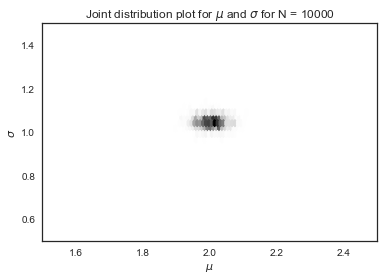

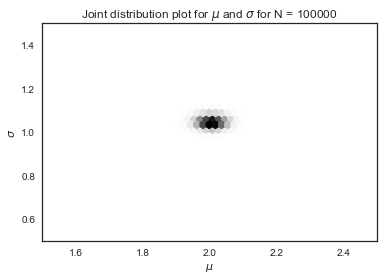

In [ ]:
N = [10000,100000,1000000]

mu_min = -10
mu_max = 10
sig_min = 0.1
sig_max = 10
delta = 0.1

#for n in N:
#    mcmc(n,mu_min,mu_max,sig_min,sig_max,delta,'data.out')

# part e
for n in N:
    heatmap('mcmc_N_{}.out'.format(n))

# part f
for n in N:
    findMAP('mcmc_N_{}.out'.format(n))

# part g
for n in N:
    findMean('mcmc_N_{}.out'.format(n))

# part h
for n in N:
    makeHistMu('mcmc_N_{}.out'.format(n))

# part i
for n in N:
    findCredibleInterval('mcmc_N_{}.out'.format(n))


In [ ]:
[mu,sig,posterior] = np.loadtxt('mcmc_N_10000.out', delimiter=",", unpack=False,dtype="S100")
mu = np.array([float(x.decode('UTF-8')) for x in mu])
sig = np.array([float(x.decode('UTF-8')) for x in sig])
posterior = np.array([float(Decimal(x.decode('UTF-8')).ln()) for x in posterior])

numBins = 500
hist = np.histogram(mu,numBins)
plt.hist(mu,numBins,normed=True)
plt.xlabel('\mu')
hist_center = (hist[1][1:] + hist[1][:-1]) / 2
    
total_a = (np.trapz(hist[0],x=hist_center))

    # build up trapz in theta
integrals = np.array([np.trapz(hist[0][0:i]/total_a,x=hist_center[0:i]) for i in range(len(hist_center))])

    # find closest value for 2.5%
integrals_mu_1 = abs(integrals - (2.5/100))
mu_1 = hist_center[np.argmin(integrals_mu_1)]

    # find closest value for 97.5%
integrals_mu_2 = abs(integrals - (97.5/100))
mu_2 = hist_center[np.argmin(integrals_mu_2)]

print('mu 1 = {}, mu 2 = {}'.format(mu_1,mu_2))
      
"""
ind_i = np.argmax(posterior)
mu_max = mu[ind_i]
sig_max = sig[ind_i]
"""
N = len(mu)
H,x,y = np.histogram2d(mu, sig, bins=100, range=None, normed=True, weights=None)

plt.figure()
with sns.axes_style("white"):
    sns.jointplot(x=mu, y=sig, kind="hex", color="k",xlim=[1,3],ylim=[0.5,1.5]);

np.unique(mu)

In [36]:
n = 100
mcmc(n,mu_min,mu_max,sig_min,sig_max,delta,'data.out')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


(array([[ 6.10158505,  4.49421446],
        [ 6.10158505,  4.49421446],
        [ 6.10158505,  4.49421446],
        [ 6.10158505,  4.49421446],
        [ 6.10158505,  4.49421446],
        [ 6.06843507,  4.50839546],
        [ 6.06843507,  4.50839546],
        [ 6.04078006,  4.51813114],
        [ 6.04078006,  4.51813114],
        [ 6.00322519,  4.49313457],
        [ 5.93265116,  4.44385839],
        [ 5.92831875,  4.36878712],
        [ 5.92831875,  4.36878712],
        [ 5.88934874,  4.28386669],
        [ 5.84631965,  4.3378501 ],
        [ 5.76112177,  4.24059971],
        [ 5.76112177,  4.24059971],
        [ 5.76112177,  4.24059971],
        [ 5.74350526,  4.31373095],
        [ 5.69694804,  4.22837194],
        [ 5.6661822 ,  4.24217661],
        [ 5.64609027,  4.2880592 ],
        [ 5.54965674,  4.22657534],
        [ 5.54965674,  4.22657534],
        [ 5.54965674,  4.22657534],
        [ 5.54965674,  4.22657534],
        [ 5.54965674,  4.22657534],
        [ 5.54965674,  4.226

In [24]:
scipy.stats.norm.pdf(0,1).data([0,1,2])

TypeError: 'memoryview' object is not callable

In [29]:
np.prod(np.array([1,2,3,4]))

24

In [15]:
Decimal('10').ln()

Decimal('2.30258509')